In [1]:
from gibbs.dataclass import GibbsResult
import matplotlib.pyplot as plt
import numpy as np
from gibbs.learning.bayesian_learning import BayesianLearning
from gibbs.learning.constraint_matrix import ConstraintMatrixFactory
from qiskit.quantum_info import Statevector
from gibbs.learning.klocal_pauli_basis import KLocalPauliBasis
from scipy.linalg import block_diag
from scipy.sparse import bmat
from qiskit.quantum_info import state_fidelity
from gibbs.utils import number_of_elements, simple_purify_hamiltonian, spectral_dec
# plt.rcParams['text.usetex'] = True

%load_ext autoreload
%autoreload 2


In [2]:
import os
gibbs_result_list = []
folder_path = "saved_simulations/turbo/allcontrols4heisenberg"
for file in os.listdir(folder_path):
    if file.endswith(".npy"):
        path = os.path.join(folder_path, file)
        gibbs_result_list.append(GibbsResult.load(path))

nfields = 3
gibbs_result_list = gibbs_result_list[:nfields+1]

c_original_prior = gibbs_result_list[0].coriginal        
states = [r.state for r in gibbs_result_list]
control_fields = [r.coriginal - c_original_prior for r in gibbs_result_list]

/home/drudis/python_environements/test_easy_instalation/lib64/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


The control error is: 3.93e-03
The preparation error is:5.62e-02


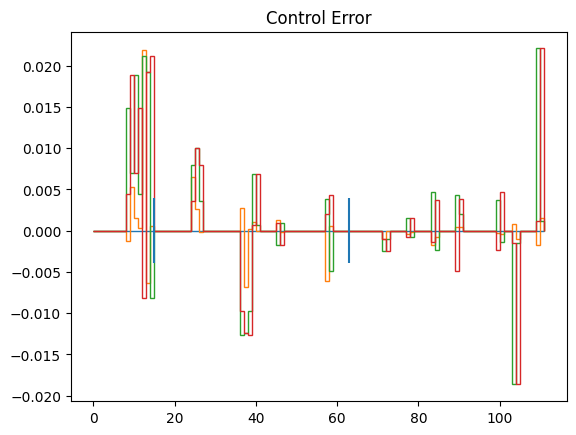

In [3]:
k=gibbs_result_list[0].klocality
n=gibbs_result_list[0].num_qubits
basisH = KLocalPauliBasis(k,n)
preparationH = gibbs_result_list[0].cfaulties[-1]
preparation_state = Statevector(gibbs_result_list[0].state)


#Faulty prep with control field - Original faulty prep - (Original H - Control H)
control_error_vectors = [(r.cfaulties[-1]-preparationH) - (r.coriginal - gibbs_result_list[0].coriginal) for r in gibbs_result_list]
for err_vec in control_error_vectors:
    plt.stairs(err_vec)

control_noise = np.std(np.concatenate(control_error_vectors))
prep_noise = np.std(gibbs_result_list[0].cfaulties[-1]-c_original_prior)

plt.vlines([KLocalPauliBasis(4,2).size,KLocalPauliBasis(4,3).size,],[-control_noise]*2,[control_noise]*2)
plt.title("Control Error")

print(f"The control error is: {control_noise:.2e}")
print(f"The preparation error is:{prep_noise:.2e}")

In [4]:
shots = 1e10
initial_arguments = {
    "states":states,
    "control_fields": control_fields,
    "constraint_matrix_factory": ConstraintMatrixFactory(n,k,k),
    "prior_mean": c_original_prior,
    "prior_covariance": (prep_noise,control_noise),
    "sampling_std": 1/np.sqrt(shots),
    "shots": shots
    }
print(len(states))
bl = BayesianLearning(**initial_arguments)
print(f"With {n} qubits and {k}-local basis will need to sample {KLocalPauliBasis(2*k,n,False).size} Paulis for each one of the states. In total,{int((nfields+1)*shots*KLocalPauliBasis(2*k,n,False).size):.1E} measurement shots as opposed to {4**n*shots:.1E} for full state tomograhy.")

4
With 4 qubits and 3-local basis will need to sample 255 Paulis for each one of the states. In total,1.0E+13 measurement shots as opposed to 2.6E+12 for full state tomograhy.


We start with a hamiltonian error of:0.5993685831967875 and end up with 1.4675559979035357 
The prior fidelity is: 0.9558332703528971 and the posterior fidelity is: 0.699227569918004


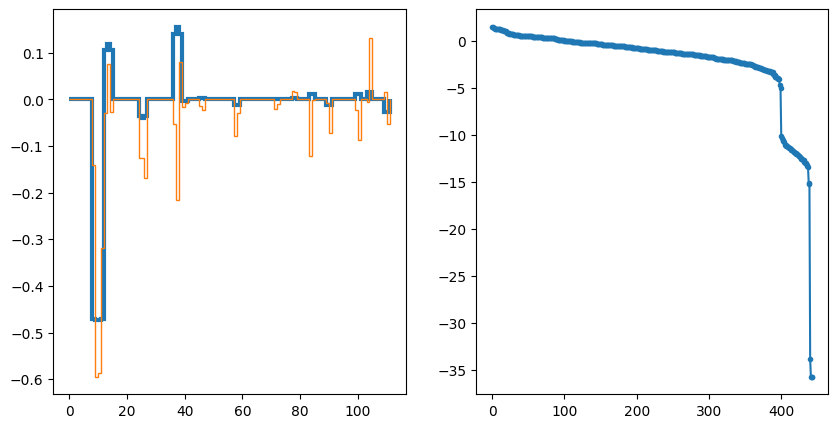

In [5]:
bl.constraint_matrix(0);
A = bl.block_control_matrix(bl.constraint_matrices)
s,v = spectral_dec(A)
candidate = v[-1][:preparationH.size].copy(); candidate /= np.linalg.norm(candidate)
if np.linalg.norm(preparationH/np.linalg.norm(preparationH) + candidate) < np.linalg.norm(preparationH/np.linalg.norm(preparationH) - candidate):
    candidate = -candidate  
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].stairs(preparationH/np.linalg.norm(preparationH),lw=3)
ax[0].stairs(candidate)
ax[1].plot(np.log(s),marker=".")
print(f"We start with a hamiltonian error of:{np.linalg.norm(c_original_prior-preparationH)} and end up with {np.linalg.norm(candidate*np.linalg.norm(preparationH)-preparationH)} ")
print(f"The prior fidelity is: {state_fidelity(simple_purify_hamiltonian(basisH.vector_to_pauli_op(c_original_prior)),simple_purify_hamiltonian(basisH.vector_to_pauli_op(preparationH)))} and the posterior fidelity is: {state_fidelity(simple_purify_hamiltonian(basisH.vector_to_pauli_op(candidate*np.linalg.norm(preparationH))),simple_purify_hamiltonian(basisH.vector_to_pauli_op(preparationH)))}")

In [6]:
minimization_problem = bl.minimization_problem()
cb = minimization_problem.pop("callback")
# minimization_problem["x0"] *= 0
from scipy.optimize import minimize
print(f"We start with{cb(minimization_problem['x0'])}")
def callback(x):
    print(cb(x))

result = minimize(**minimization_problem,options={"maxiter":1e5,"xrtol":1e-3,"disp":True},callback=None)
print(result)

(444,) (444, 444)
We start with(5803.943648642742, 0.0)


/home/drudis/python_environements/test_easy_instalation/lib64/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:107: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x0).astype(float)
/home/drudis/python_environements/test_easy_instalation/lib64/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:243: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)


Optimization terminated successfully.
         Current function value: 5.055243
         Iterations: 221
         Function evaluations: 110805
         Gradient evaluations: 249
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 5.0552433342907905
        x: [-0.00018324+0.j -0.00050676+0.j ... -0.01193467+0.j
             0.00746235+0.j]
      nit: 221
      jac: [-2.026e+00 -2.582e+00 ...  3.019e-01 -1.119e-01]
 hess_inv: [[ 3.323e-01  4.676e-02 ... -4.896e-03 -3.232e-04]
            [ 4.676e-02  5.722e-01 ...  9.592e-04  1.087e-04]
            ...
            [-4.896e-03  9.592e-04 ...  9.067e-01  1.312e-02]
            [-3.232e-04  1.087e-04 ...  1.312e-02  9.576e-01]]
     nfev: 110805
     njev: 249


In [7]:
# update = bl.update_mean()
update = result.x
cov = bl.update_cov(update)

In [205]:
# fig,ax = plt.subplots(1,2,figsize=(15,5))
# ax[0].stairs(gibbs_result_list[0].cfaulties[-1],label="preparation")
# ax[0].stairs(c_original_prior,label = "prior")
# ax[0].stairs(update[:c_original_prior.size],label="posterior")
# ax[0].legend(loc = "lower right")
# width = 0.9
# ax[1].bar(np.arange(bl.size),np.abs(gibbs_result_list[0].cfaulties[-1]-c_original_prior),width,label="prior error",lw=2,fill=True)
# ax[1].bar(np.arange(bl.size),np.abs(gibbs_result_list[0].cfaulties[-1]-update[:c_original_prior.size]),0.6*width,label="Posterior Error",fill=True)
# ax[1].stairs(cov.diagonal()[:c_original_prior.size],np.arange(bl.size+1)-1/2,label="std",color="red")
# ax[1].hlines([prep_noise],[0],[80])
# ax[1].legend()
# # ax[2].stairs(update,label="posterior")
# # ax[2].stairs(cov.diagonal(),label="posterior std")
# # ax[2].vlines([bl.size],[-1],[0.4],color="black",linestyles="dotted")
# # ax[2].legend()

print(f"We start with a hamiltonian error of:{np.linalg.norm(c_original_prior-preparationH):.5f} and end up with {np.linalg.norm(update[:c_original_prior.size]-preparationH):.5f} ")
print(f"The prior fidelity is: {state_fidelity(simple_purify_hamiltonian(basisH.vector_to_pauli_op(c_original_prior)),preparation_state):.5f} and the posterior fidelity is: {state_fidelity(simple_purify_hamiltonian(basisH.vector_to_pauli_op(update[:c_original_prior.size])),preparation_state):.5f}")
print(f"This means we would have estimated our state to have a fidelity of {state_fidelity(simple_purify_hamiltonian(basisH.vector_to_pauli_op(c_original_prior)),simple_purify_hamiltonian(basisH.vector_to_pauli_op(update[:c_original_prior.size]))):.5f} when it actually had a fidelity of {state_fidelity(simple_purify_hamiltonian(basisH.vector_to_pauli_op(preparationH)),simple_purify_hamiltonian(basisH.vector_to_pauli_op(c_original_prior)) )}")

We start with a hamiltonian error of:0.59937 and end up with 0.24995 
The prior fidelity is: 0.96002 and the posterior fidelity is: 0.98804
This means we would have estimated our state to have a fidelity of 0.96607 when it actually had a fidelity of 0.9558332703528971


In [204]:
import plotly.express as px
import plotly.graph_objects as go

local_sizes = np.array([0]+[KLocalPauliBasis(i+1,4).size for i in range(3)])
local_positions = local_sizes[1:]-local_sizes[:-1]
local_labels = np.concatenate([[f"{i+1}-local"]*local_positions[i] for i in range(local_positions.size)])
data = {
    "Pauli Basis Label":KLocalPauliBasis(3,4)._paulis_list,
    "Pauli Basis":np.arange(KLocalPauliBasis(3,4).size),
    "locality":local_labels,
    "prepH":np.real(gibbs_result_list[0].cfaulties[-1]),
    "priorH":np.real(c_original_prior),
    "posteriorH":update[:c_original_prior.size],
    "Posterior Std": np.real(cov.diagonal()[:c_original_prior.size])
}
data["Prior Error"] = np.abs(data["priorH"]-data["prepH"])
data["Posterior Error"] = np.abs(data["posteriorH"]-data["prepH"])

# fig = px.bar(data, x='paulibasis', y=['prepH','priorH'],barmode="overlay")
fig = px.bar(data, x='Pauli Basis', y=["Prior Error","Posterior Error"],color_discrete_sequence=["blue", "red"],
             barmode="overlay", hover_name="Pauli Basis Label"
             )
fig.add_trace(
    go.Scatter(
        x=data["Pauli Basis"]-0.5,
        y=data["Posterior Std"],
        mode="lines",
        line={"shape": 'hv',"color":"black"},
        name="Posterior Std",
        showlegend=True)
)
fig.update_layout(
    xaxis = dict(
        tickvals =local_sizes[:-1]-0.5,
        ticktext = ["1-local","2-local","3-local"],
        ticks="outside",
        showgrid=True,
        tickson="boundaries",
        ticklen=5),
    title="Prior vs Posterior Error",
    xaxis_title="Pauli Basis",
    yaxis_title="Reconstruction Error",
    legend_title="",
    font={"size":18,"color":"black"},
    legend={"yanchor":"top","y":0.99,"xanchor":"right","x":0.99}
)
fig.show()